In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
import sys
import scipy.io as sio
import h5py


sys.path.append('/mlodata1/lugeon/eeg_dream/scripts')

sns.set_context("paper")
sns.set(font_scale = 1.6)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

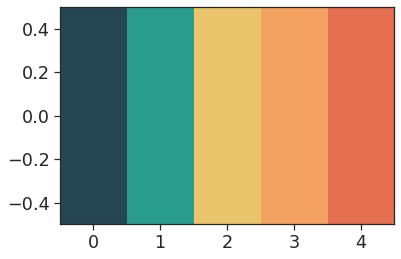

In [2]:
from matplotlib import colors
palette = ['#264653', '#2A9D8F','#E9C46A', '#F4A261', '#E76F51']
cmap = colors.ListedColormap(palette)

plt.imshow(np.arange(len(palette)).reshape(1, -1), aspect='auto', cmap=cmap,origin="lower")
plt.show()

## Electrodes locations

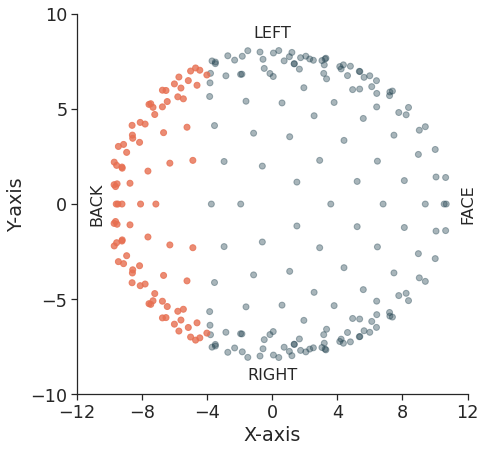

In [3]:
e_locs = sio.loadmat('/mlodata1/lugeon/dream_data/chuv/metadata/original/channelcoords.mat')['locstemp']

e_upper_limit = {
    'x': -4,
    'y': None,
    'z': None
}

mask = np.ones(e_locs.shape[0]).astype(bool)
    
for index, axis in enumerate(['x', 'y', 'z']):

    if e_upper_limit[axis] is not None:
        axis_mask = e_locs[:, index] <= e_upper_limit[axis]
        mask = mask & axis_mask    
        
colors = [cmap(4) if m else cmap(0) for m in mask]
alphas = [0.8 if m else 0.4 for m in mask]

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()

ax.scatter(e_locs[:, 0], e_locs[:, 1], color=colors, alpha=alphas)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

plt.xlim([-12, 12])
plt.ylim([-10, 10])

ax.set_xticks([-12, -8, -4, 0, 4, 8, 12])
ax.set_yticks([-10, -5, -0, 5, 10])

plt.text(-10.8, 0, 'BACK', ha='center', va='center', rotation='vertical', size=16)
plt.text(12, 0, 'FACE', ha='center', va='center', rotation='vertical', size=16)
plt.text(0, 9, 'LEFT', ha='center', va='center', size=16)
plt.text(0, -9, 'RIGHT', ha='center', va='center', size=16)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 

plt.savefig('img/electrode_loc.pdf', bbox_inches='tight')

plt.show()

In [4]:
e_locs[:, 0].min()

-9.716560000000001

## Basic statistics

#### H-subjects

In [5]:
hdf5_file = '/mlodata1/lugeon/dream_data/processed/healthy_full/dataset.h5'

with h5py.File(hdf5_file, 'r') as f:
    subjects = [s.decode('utf-8') for s in f['subject_name'][:]]
    subject_id = f['subject_id'][:]
    trial_id = f['trial_id'][:]
    sleep_stage = f['sleep_stage'][:]
    labels = f['labels'][:]
    
subjects

['H009',
 'H018',
 'H019',
 'H021',
 'H025',
 'H026',
 'H033',
 'H035',
 'H048',
 'H050',
 'H051',
 'H054',
 'H055',
 'H057',
 'H060',
 'H089',
 'H099',
 'H100',
 'H061',
 'H068']

In [6]:
df = pd.DataFrame({'sid': subject_id, 'tid': trial_id, 'ss': sleep_stage, 'label': labels})
df

,sid,tid,ss,label
0,0.0,0.0,3.0,1.0
1,0.0,0.0,3.0,1.0
2,0.0,0.0,3.0,1.0
3,0.0,0.0,3.0,1.0
4,0.0,0.0,3.0,1.0
...,...,...,...,...
123472,19.0,30.0,4.0,1.0
123473,19.0,30.0,4.0,1.0
123474,19.0,30.0,4.0,1.0
123475,19.0,30.0,4.0,1.0


In [7]:
trial_count = df.drop_duplicates(['sid', 'tid']).groupby(['sid', 'ss', 'label']).tid.count()
trial_count.sum()

521

In [8]:
trials = df.drop_duplicates(['sid', 'tid'])

In [9]:
trials

,sid,tid,ss,label
0,0.0,0.0,3.0,1.0
237,0.0,1.0,2.0,1.0
474,0.0,2.0,2.0,1.0
711,0.0,3.0,2.0,1.0
948,0.0,4.0,2.0,2.0
...,...,...,...,...
122292,19.0,26.0,2.0,1.0
122529,19.0,27.0,2.0,1.0
122766,19.0,28.0,2.0,2.0
123003,19.0,29.0,4.0,1.0


In [10]:
rem_ne = trials.groupby('sid').apply(lambda g: sum((g.ss == 4) & (g.label == 0)))
rem_de = trials.groupby('sid').apply(lambda g: sum((g.ss == 4) & (g.label == 2)))
rem_dewr = trials.groupby('sid').apply(lambda g: sum((g.ss == 4) & (g.label == 1)))

nrem_ne = trials.groupby('sid').apply(lambda g: sum((g.ss != 4) & (g.label == 0)))
nrem_de = trials.groupby('sid').apply(lambda g: sum((g.ss != 4) & (g.label == 2)))
nrem_dewr = trials.groupby('sid').apply(lambda g: sum((g.ss != 4) & (g.label == 1)))

tot_ne = rem_ne + nrem_ne
tot_de = rem_de + nrem_de
tot_dewr = rem_dewr + nrem_dewr

In [11]:
trials.shape[0]

521

In [12]:
rem_ne.sum() + rem_de.sum() + rem_dewr.sum(), nrem_ne.sum() + nrem_de.sum() + nrem_dewr.sum()

(121, 400)

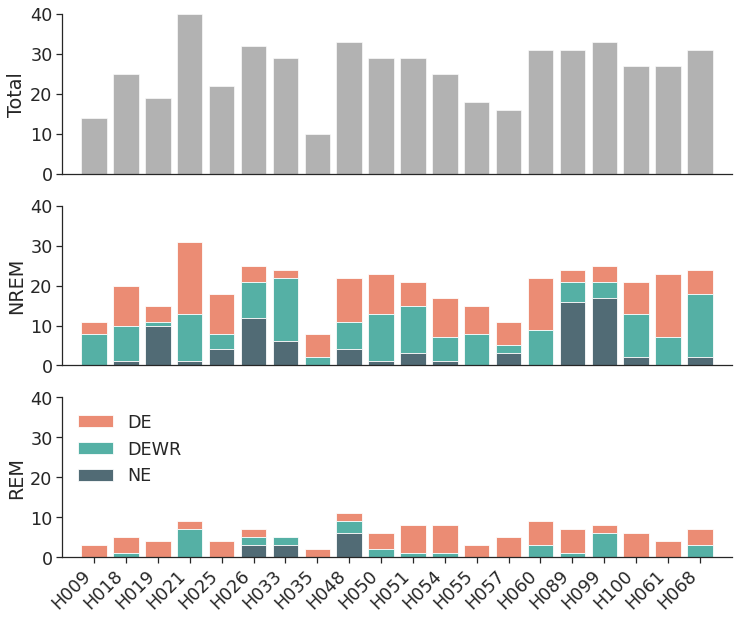

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

x = np.arange(len(subjects))

axs[0].bar(x, tot_ne + tot_de + tot_dewr, color='grey', alpha=0.6)

axs[1].bar(x, nrem_de, bottom=nrem_ne+nrem_dewr, color=cmap(4), alpha=0.8)
axs[1].bar(x, nrem_dewr, bottom=nrem_ne, color=cmap(1), alpha=0.8)
axs[1].bar(x, nrem_ne, color=cmap(0), alpha=0.8)

axs[2].bar(x, rem_de, label='DE', bottom=rem_ne+rem_dewr, color=cmap(4), alpha=0.8)
axs[2].bar(x, rem_dewr, label='DEWR', bottom=rem_ne, color=cmap(1), alpha=0.8)
axs[2].bar(x, rem_ne, label='NE', color=cmap(0), alpha=0.8)

axs[0].set_ylabel('Total')
axs[1].set_ylabel('NREM')
axs[2].set_ylabel('REM')

axs[0].set_ylim([0, 40])
axs[1].set_ylim([0, 40])
axs[2].set_ylim([0, 40])

axs[0].set_xlim([-1, len(subjects)])
axs[1].set_xlim([-1, len(subjects)])
axs[2].set_xlim([-1, len(subjects)])

axs[0].set_yticks([0, 10, 20, 30, 40])
axs[1].set_yticks([0, 10, 20, 30, 40])
axs[2].set_yticks([0, 10, 20, 30, 40])

axs[0].set_xticks([])
axs[1].set_xticks([])
axs[2].set_xticks(x)
axs[2].set_xticklabels(subjects, rotation=45, ha='right')

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 

legend = axs[2].legend(frameon=False, loc='upper left')
plt.savefig('img/h_dataset.pdf', bbox_inches='tight')

plt.plot();

In [14]:
# trials percentage in NREM sleep
( nrem_ne.sum() + nrem_de.sum() + nrem_dewr.sum() ) / trials.shape[0]

0.7677543186180422

In [15]:
# trials percentage in REM sleep
( rem_ne.sum() + rem_de.sum() + rem_dewr.sum() ) / trials.shape[0]

0.23224568138195778

In [16]:
# fraction of DE in NREM sleep (DEWR excluded)
nrem_de.sum() / (nrem_de.sum() + nrem_ne.sum())

0.6541666666666667

In [17]:
nrem_de.sum(), nrem_ne.sum()

(157, 83)

In [18]:
trials.label.value_counts() / trials.shape[0]

2.0    0.449136
1.0    0.368522
0.0    0.182342
Name: label, dtype: float64

In [19]:
trials.sid.value_counts()

3.0     40
8.0     33
16.0    33
5.0     32
19.0    31
15.0    31
14.0    31
9.0     29
10.0    29
6.0     29
17.0    27
18.0    27
1.0     25
11.0    25
4.0     22
2.0     19
12.0    18
13.0    16
0.0     14
7.0     10
Name: sid, dtype: int64

#### M-subjects

In [20]:
hdf5_file = '/mlodata1/lugeon/dream_data/processed/madison_full/dataset.h5'

with h5py.File(hdf5_file, 'r') as f:
    subjects = [s.decode('utf-8') for s in f['subject_name'][:]]
    subject_id = f['subject_id'][:]
    trial_id = f['trial_id'][:]
    sleep_stage = f['sleep_stage'][:]
    labels = f['labels'][:]
    
subjects

['M001', 'M002', 'M003', 'M004', 'M005', 'M006', 'M007']

In [21]:
df = pd.DataFrame({'sid': subject_id, 'tid': trial_id, 'ss': sleep_stage, 'label': labels})
df

,sid,tid,ss,label
0,0.0,0.0,3.0,2.0
1,0.0,0.0,3.0,2.0
2,0.0,0.0,3.0,2.0
3,0.0,0.0,3.0,2.0
4,0.0,0.0,3.0,2.0
...,...,...,...,...
140536,6.0,69.0,3.0,0.0
140537,6.0,69.0,3.0,0.0
140538,6.0,69.0,3.0,0.0
140539,6.0,69.0,3.0,0.0


In [22]:
trial_count = df.drop_duplicates(['sid', 'tid']).groupby(['sid', 'ss', 'label']).tid.count()
trial_count.sum()

593

In [23]:
trials = df.drop_duplicates(['sid', 'tid'])

In [24]:
trials

,sid,tid,ss,label
0,0.0,0.0,3.0,2.0
237,0.0,1.0,3.0,0.0
474,0.0,2.0,3.0,0.0
711,0.0,3.0,3.0,2.0
948,0.0,4.0,2.0,2.0
...,...,...,...,...
139356,6.0,65.0,2.0,0.0
139593,6.0,66.0,2.0,2.0
139830,6.0,67.0,3.0,0.0
140067,6.0,68.0,2.0,0.0


In [25]:
rem_ne = trials.groupby('sid').apply(lambda g: sum((g.ss == 4) & (g.label == 0)))
rem_de = trials.groupby('sid').apply(lambda g: sum((g.ss == 4) & (g.label == 2)))
rem_dewr = trials.groupby('sid').apply(lambda g: sum((g.ss == 4) & (g.label == 1)))

nrem_ne = trials.groupby('sid').apply(lambda g: sum((g.ss != 4) & (g.label == 0)))
nrem_de = trials.groupby('sid').apply(lambda g: sum((g.ss != 4) & (g.label == 2)))
nrem_dewr = trials.groupby('sid').apply(lambda g: sum((g.ss != 4) & (g.label == 1)))

tot_ne = rem_ne + nrem_ne
tot_de = rem_de + nrem_de
tot_dewr = rem_dewr + nrem_dewr

In [26]:
trials.shape[0]

593

In [27]:
rem_ne.sum() + rem_de.sum() + rem_dewr.sum() + nrem_ne.sum() + nrem_de.sum() + nrem_dewr.sum()

593

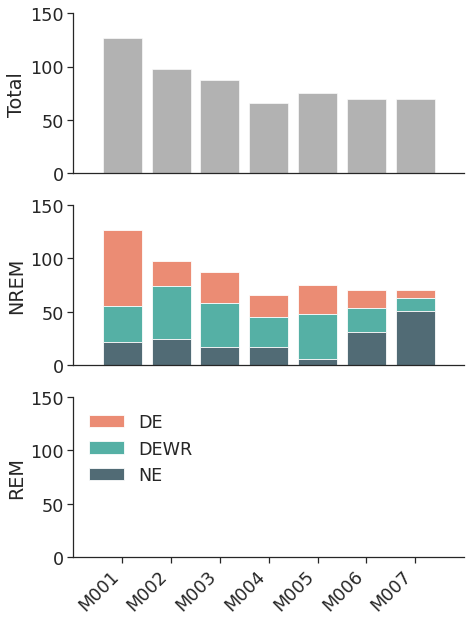

In [29]:
fig, axs = plt.subplots(3, 1, figsize=(7, 10))

x = np.arange(len(subjects))

axs[0].bar(x, tot_ne + tot_de + tot_dewr, color='grey', alpha=0.6)

axs[1].bar(x, nrem_de, bottom=nrem_ne+nrem_dewr, color=cmap(4), alpha=0.8)
axs[1].bar(x, nrem_dewr, bottom=nrem_ne, color=cmap(1), alpha=0.8)
axs[1].bar(x, nrem_ne, color=cmap(0), alpha=0.8)

axs[2].bar(x, rem_de, label='DE', bottom=rem_ne+rem_dewr, color=cmap(4), alpha=0.8)
axs[2].bar(x, rem_dewr, label='DEWR', bottom=rem_ne, color=cmap(1), alpha=0.8)
axs[2].bar(x, rem_ne, label='NE', color=cmap(0), alpha=0.8)

axs[0].set_ylabel('Total')
axs[1].set_ylabel('NREM')
axs[2].set_ylabel('REM')

axs[0].set_ylim([0, 150])
axs[1].set_ylim([0, 150])
axs[2].set_ylim([0, 150])

axs[0].set_xlim([-1, len(subjects)])
axs[1].set_xlim([-1, len(subjects)])
axs[2].set_xlim([-1, len(subjects)])

axs[0].set_yticks([0, 50, 100, 150])
axs[1].set_yticks([0, 50, 100, 150])
axs[2].set_yticks([0, 50, 100, 150])

axs[0].set_xticks([])
axs[1].set_xticks([])
axs[2].set_xticks(x)
axs[2].set_xticklabels(subjects, rotation=45, ha='right')

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 

legend = axs[2].legend(frameon=False, loc='upper left')
plt.savefig('img/m_dataset.pdf', bbox_inches='tight')

plt.plot();

In [29]:
trials.sid.value_counts()

0.0    127
1.0     98
2.0     87
4.0     75
5.0     70
6.0     70
3.0     66
Name: sid, dtype: int64

In [30]:
# fraction of DE in NREM sleep (DEWR excluded)
nrem_de.sum() / (nrem_de.sum() + nrem_ne.sum())

0.5384615384615384

In [31]:
nrem_de.sum(), nrem_ne.sum()

(196, 168)

### Baseline recordings

In [32]:
with np.load('/mlodata1/lugeon/dream_data/processed/baseline/freq/H009.npz') as f:
    for k in f:
        signal = f[k]
        break

FileNotFoundError: [Errno 2] No such file or directory: '/mlodata1/lugeon/dream_data/processed/baseline/freq/H009.npz'

In [ ]:
signal.shape

(8637, 256, 5)

In [ ]:
seconds = 0

for i in glob.glob('/mlodata1/lugeon/dream_data/chuv/baseline/H*/NREM_*.mat'):
    with h5py.File(i,'r') as file:
        time_signal = np.array(file['datavr'])
        seconds += time_signal.shape[0] / 500

In [ ]:
seconds

236220.0

### Sleep stage distribution

In [ ]:
# CHUV

hdf5_file = '/mlodata1/lugeon/dream_data/processed/healthy_20sec/dataset_nrem_binary.h5'

with h5py.File(hdf5_file, 'r') as f:
    #subjects = [s.decode('utf-8') for s in f['subject_name'][:]]
    subject_id = f['subject_id'][:]
    trial_id = f['trial_id'][:]
    sleep_stage = f['sleep_stage'][:]
    labels = f['labels'][:]
    
df = pd.DataFrame({'ss': sleep_stage, 'tid': trial_id, 'sid': subject_id, 'label': labels})
df.groupby(['tid', 'sid']).ss.first().value_counts()

2.0    124
3.0    116
Name: ss, dtype: int64

In [34]:
# Madison

hdf5_file = '/mlodata1/lugeon/dream_data/processed/madison_nrem_binary/dataset_256e.h5'

with h5py.File(hdf5_file, 'r') as f:
    #subjects = [s.decode('utf-8') for s in f['subject_name'][:]]
    subject_id = f['subject_id'][:]
    trial_id = f['trial_id'][:]
    sleep_stage = f['sleep_stage'][:]
    #labels = f['labels'][:]
    
df = pd.DataFrame({'ss': sleep_stage, 'tid': trial_id, 'sid': subject_id})
df.groupby(['tid', 'sid']).ss.first().value_counts()

2.0    206
3.0    158
Name: ss, dtype: int64

## Sequence of images

In [35]:
from training.dataset import datasets

hdf5_file = '/mlodata1/lugeon/dream_data/processed/baseline_nrem/dataset_cal.h5'
#hdf5_file = '/mlodata1/lugeon/dream_data/processed/madison_nrem_binary/dataset_14e.h5'


dataset = datasets.EEG_Image_Batch_Dataset(hdf5_file, 
                                           window=10, 
                                           slide=5, 
                                           batch_size=128, 
                                           shuffle=False, 
                                           return_metadata=False,
                                           exclude_subject=[],
                                           output_type='none')

with h5py.File(dataset.hdf5_file, 'r') as f:
    subjects = [s.decode('utf-8') for s in f['subject_name'][:]]
    
dataset

/mlodata1/lugeon/miniconda3/envs/eeg-dream-conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


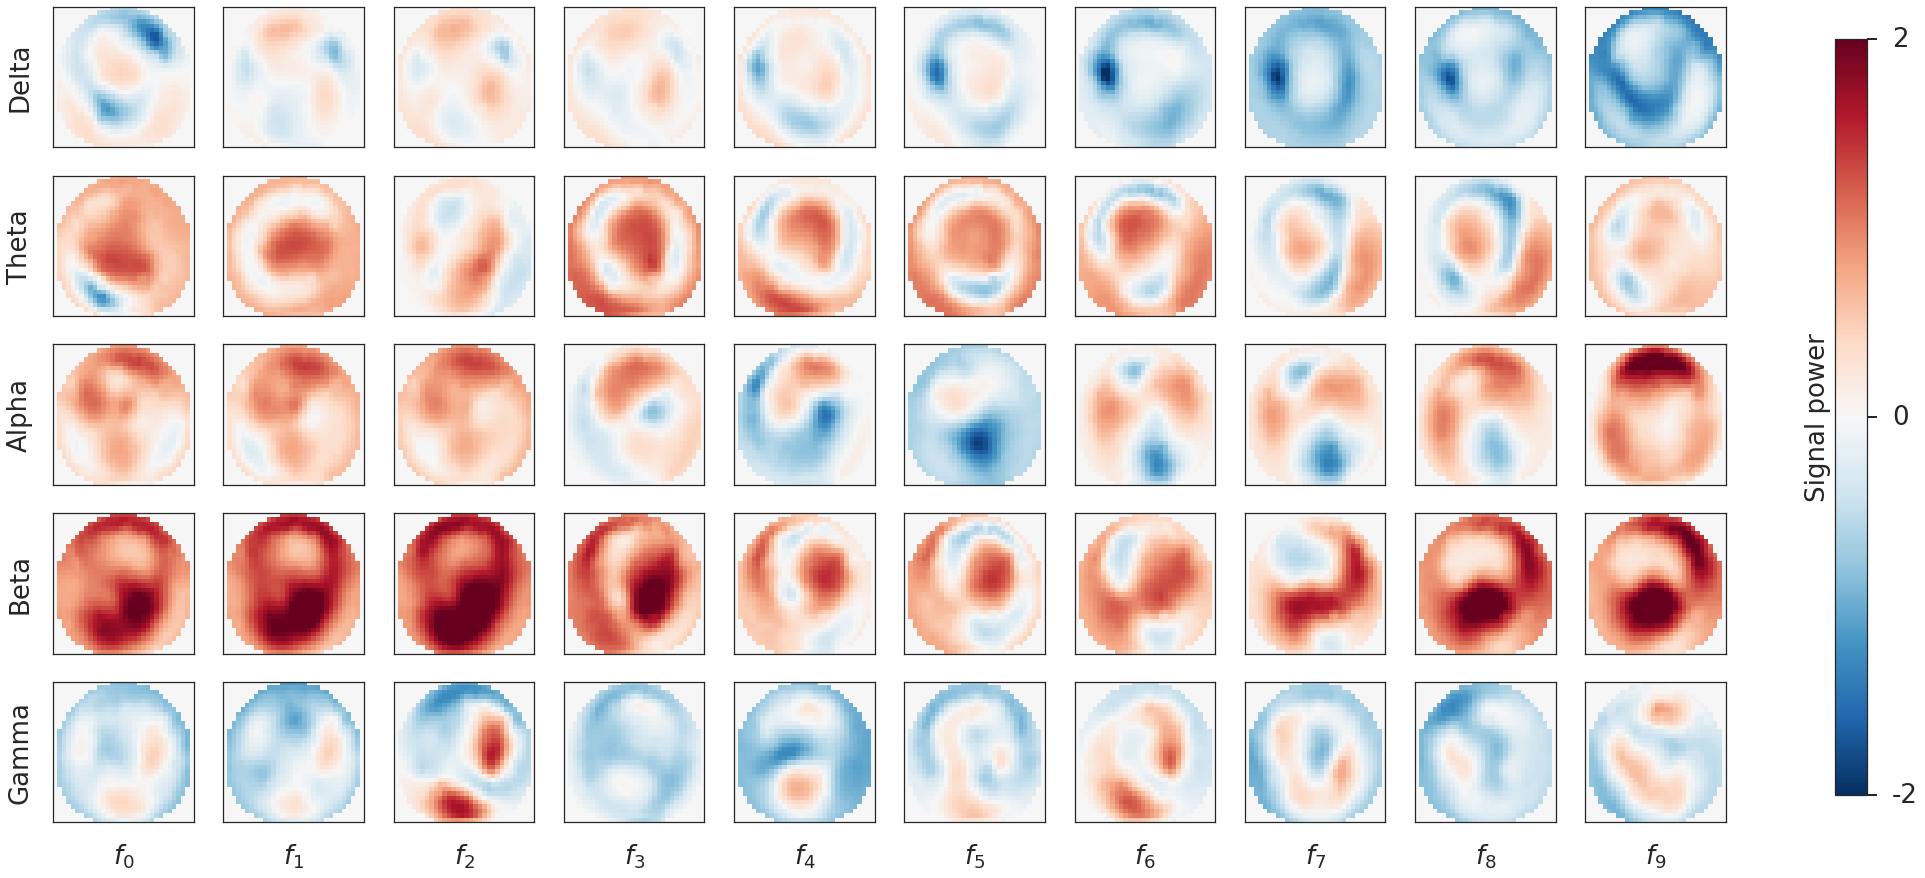

In [36]:
batch = dataset.__getitem__(0)[0]
sample = batch[9, :]

fig, ax = plt.subplots(5, 10, figsize=(30, 15))

vmin = -2
vmax = 2

seq_cmap = 'RdBu_r'

for t in range(10):
    ax[0, t].imshow(sample[t, 0, :, :], cmap=seq_cmap, vmin=vmin, vmax=vmax)
    ax[1, t].imshow(sample[t, 1, :, :], cmap=seq_cmap, vmin=vmin, vmax=vmax)
    ax[2, t].imshow(sample[t, 2, :, :], cmap=seq_cmap, vmin=vmin, vmax=vmax)
    ax[3, t].imshow(sample[t, 3, :, :], cmap=seq_cmap, vmin=vmin, vmax=vmax)
    ax[4, t].imshow(sample[t, 4, :, :], cmap=seq_cmap, vmin=vmin, vmax=vmax)
    
    for i in [0, 1, 2, 3, 4]:
        ax[i, t].set_xticks([])
        ax[i, t].set_yticks([])
        
    if t == 0:
        ax[0, t].set_ylabel('Delta', labelpad=20, fontsize=26)
        ax[1, t].set_ylabel('Theta', labelpad=20, fontsize=26)
        ax[2, t].set_ylabel('Alpha', labelpad=20, fontsize=26)
        ax[3, t].set_ylabel('Beta', labelpad=20, fontsize=26)
        ax[4, t].set_ylabel('Gamma', labelpad=20, fontsize=26)
        
    ax[4, t].set_xlabel(f'$f_{t}$', labelpad=20, fontsize=26)

cax = plt.axes([0.95, 0.15, 0.015, 0.7])
plt.colorbar(matplotlib.cm.ScalarMappable(cmap=seq_cmap), cax=cax)
cax.set_yticks([0, 0.5, 1])
cax.set_yticklabels([vmin, 0, vmax], fontsize=26, va='center')
cax.tick_params(length=10, width=2, pad=15)
cax.set_ylabel('Signal power', fontsize=26)
cax.yaxis.set_label_position("left")

plt.savefig('img/sequence_eeg_image.pdf', bbox_inches='tight')
plt.show()

## Distribution per channel

### Before normalization 

In [37]:
dir_path = '/mlodata1/lugeon/dream_data/processed/baseline_nrem/freq'

subjects = []

for file in glob.glob(f'{dir_path}/*'):
    with np.load(file) as f:
        trials = []
        for trial in f:
            signal = f[trial]
            trials.append(signal)
            
        subjects.append(np.concatenate(trials))

In [38]:
subjects[0].shape

(25422, 256, 5)

In [39]:
# means over trials and frames
log_means = [np.log(s).mean(axis=(0, 1)) for s in subjects]
means = [s.mean(axis=(0, 1)) for s in subjects]
means[0].shape

(5,)

In [40]:
# average power over all electrode, mean and std across subjects
mean_channel = []
std_channel = []
mean_channel_log = []
std_channel_log = []

for channel in range(5):
    mean_channel.append(np.mean([m[channel].mean() for m in means]))
    mean_channel_log.append(np.mean([m[channel].mean() for m in log_means]))
    std_channel.append(np.std([m[channel].mean() for m in means]))
    std_channel_log.append(np.std([m[channel].mean() for m in log_means]))

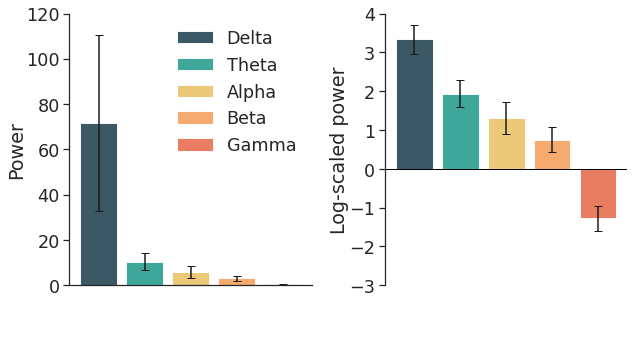

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

x = np.arange(len(mean_channel))

labels = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

for i, l in enumerate(labels):
    axs[0].bar(x[i], mean_channel[i], 
            yerr=std_channel[i], capsize=4,
            color=cmap(i), 
            alpha=0.9,
            label=labels[i])

axs[1].bar(x, mean_channel_log, 
           yerr=std_channel_log, capsize=4,
           color=[cmap(i) for i in range(5)], 
           alpha=0.9)

axs[1].set_xticks([])
axs[0].set_xticks([0], )
axs[0].set_xticklabels([0], color='white')
axs[0].tick_params(axis='x', color='white')


axs[0].set_ylabel('Power', labelpad=0)
axs[1].set_ylabel('Log-scaled power', labelpad=0)

axs[0].set_xlabel('_just_for_alignment_', color='white')


axs[0].set_ylim([0, 120])
axs[1].set_ylim([-3, 4])

#axs[1].plot([-0.5, 5], [0, 0], color='black', alpha=1, ls='-', lw=0.5)
axs[1].axhline(y=0, color='black', lw=1)

axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)

axs[0].legend(frameon=False)

plt.subplots_adjust(wspace=0.3, hspace=0)

plt.savefig('img/log_effect.pdf', bbox_inches='tight')
plt.show()

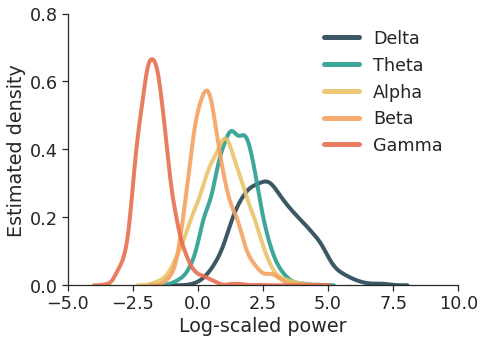

In [78]:
subject = 6
signal = subjects[subject]

bandwidths = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

fig, ax = plt.subplots(figsize=(7, 5))

for bw in range(signal.shape[2]):
    f = np.log(signal[:, :, bw].flatten())
    samples = np.random.choice(f, size=2000, replace=False)

    sns.kdeplot(samples, ax=ax, linewidth=4, color=cmap(bw), alpha=0.9, label=bandwidths[bw])
    
    
legend = plt.legend(frameon=False)
# set the linewidth of each legend object
for legobj in legend.legendHandles:
    legobj.set_linewidth(5.0)

plt.ylabel('Estimated density')
plt.xlabel('Log-scaled power')


plt.ylim(0, 0.8)
plt.xlim(-5, 10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('img/frequency_density.pdf', bbox_inches='tight')

plt.show()

In [79]:
snames[subject]

'H018'